# **Aerial Cactus Identification using CNN**

*By Andrés Rubio Ramos (rubioand) for the course NIE-MVI*

## Exploratory Data Analysis

Exploratory Data Analysis (EDA) serves as the foundational step in understanding the characteristics and patterns within our aerial cactus dataset.

Through EDA, we aim to gain insights into the distribution, relationships, and potential anomalies present in the data before diving into the convolutional neural network (CNN) model development.

By visualizing and summarizing key statistics of the dataset during EDA, we can make informed decisions regarding preprocessing steps and feature engineering for optimal model performance.

### 1º Load the data

In [ ]:
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

submission=pd.read_csv('sample_submission.csv')
labels=pd.read_csv('train.csv')

In [ ]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [ ]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


The id is the image filename of the test or training data. has_cactus is the target value. It indicates whether an image with that filename contains a cactus. A value of 0 means it doesn't have a cactus, and a value of 1 means it does.

### 2º Data Visualization

Utilizing various plotting techniques, data visualization allows us to grasp the distributional characteristics and relationships among different features, setting the stage for effective model development.

⚫ Frequency distribution of the target variable

([<matplotlib.patches.Wedge at 0x7d3cb465ca90>,
 [Text(-0.7793519565739234, 0.7762799287527649, 'HAS CACTUS'),
  Text(0.7793519929142085, -0.776279892268666, "HASN'T CACTUS")],
 [Text(-0.42510106722213997, 0.42342541568332626, '75.1%'),
  Text(0.4251010870441137, -0.42342539578290866, '24.9%')])

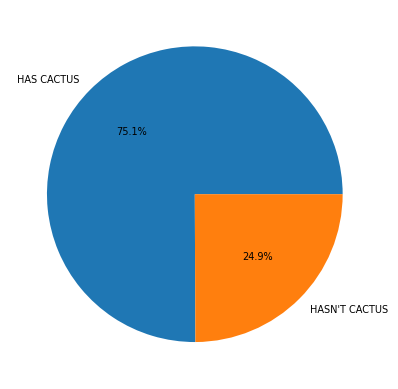

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.pie(labels['has_cactus'].value_counts(), labels=['HAS CACTUS', 'HASN\'T CACTUS'], autopct= '%.1f%%')

With this circular graph we can see that there are three times as many photos with cactus compared to those without cactus. If we consider a deterministic model that always answered that if the photo has cactus, it would have an accuracy of 75.1% if we assume that the training data reflects very well the proportion of the data that we would find in real practice.

⚫ Image Inspection

Since this project comes from a Kaggle competition, I am going to use the same training and test data set that comes with images compressed in a zip. So first I have to unzip them.

In [ ]:
from zipfile import ZipFile

with ZipFile('train.zip') as zipper:
  zipper.extractall()

with ZipFile('test.zip') as zipper:
  zipper.extractall()

Once extracted, it would be interesting to see how many images we have for our training and then to test the effectiveness of our CNN.

In [ ]:
import os

trainAmount=len(os.listdir('train'))
testAmount=len(os.listdir('test'))

print('The amount of train images is: '+str(trainAmount))
print('The amount of test images is: '+str(testAmount))

The amount of train images is: 17500
The amount of test images is: 4000


Let's display some training image data. We'll utilize the OpenCV library for reading these images. OpenCV, an open-source computer vision tool. First, we'll showcase 10 images featuring cactus.

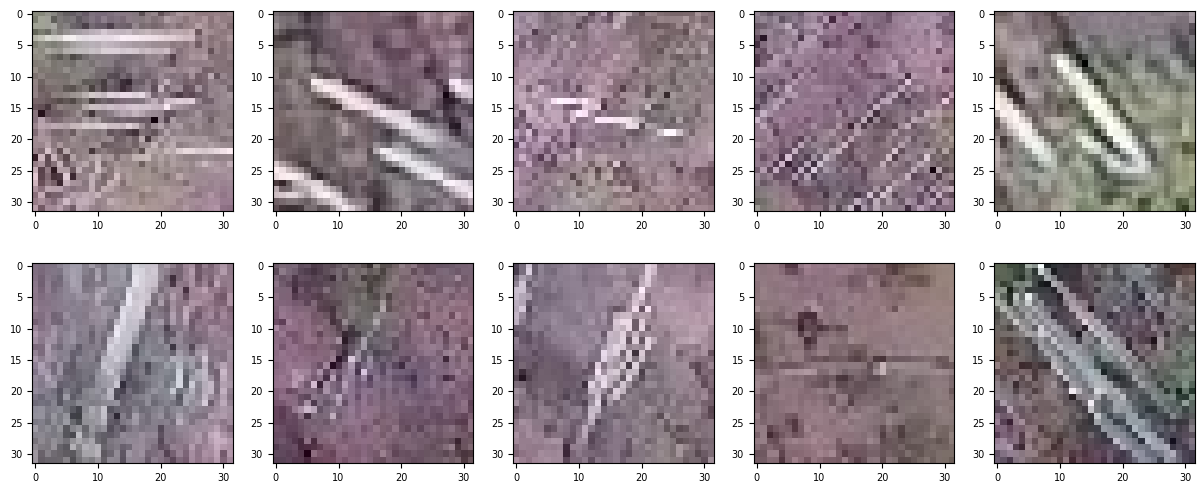

In [ ]:
import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size=7)
plt.figure(figsize=(15,6))
grid=gridspec.GridSpec(2,5)

hasCactusImages=labels[labels['has_cactus']==1]['id'][:10]

for ind, name in enumerate(hasCactusImages):
  image=cv2.imread('train/'+name)
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  ax=plt.subplot(grid[ind])
  ax.imshow(image)

The truth is that it is very difficult even for us to differentiate if there is a cactus or not, but those elongated figures are the cactus present in the images.

Now let's see training images in which no cactus is present. We are going to show another 10 so that we can see the differences between the two classifications.

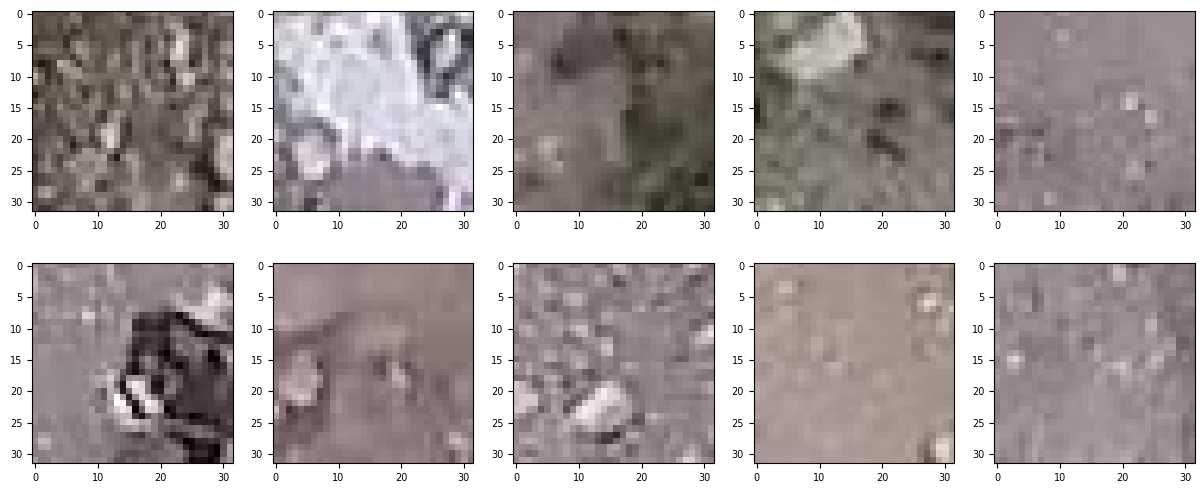

In [ ]:
mpl.rc('font', size=7)
plt.figure(figsize=(15,6))
grid=gridspec.GridSpec(2,5)

hasCactusImages=labels[labels['has_cactus']==0]['id'][:10]

for ind, name in enumerate(hasCactusImages):
  image=cv2.imread('train/'+name)
  image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  ax=plt.subplot(grid[ind])
  ax.imshow(image)

In [ ]:
image.shape

(32, 32, 3)

Upon inspection, we observe that the image dimensions are 32 pixels in width and 32 pixels in height, encompassing three distinct color channels. This tri-channel structure indicates that the image is in color format, specifically representing the red, green, and blue color spectrums.

### 3º Approach to building the model

-The image files are low resolution color images.

-The ID of the CSV file is the image filename. You can get the location of the file by simply adding the file's pathname.

With these characteristics and seeing the problem to be solved, I think it would be very good to try to use a CNN to solve it. Given the characteristics of the images (low resolution, color) and the inherent advantages of CNNs in image processing and analysis, it is a good decision to use a CNN to develop a cactus classifier. The ability of CNN to efficiently capture and utilize relevant features in low-resolution, low-color images provides a good solution to address this specific image classification problem.

## Modeling

In [ ]:
!nvidia-smi

Tue Jan  9 14:27:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0              26W /  70W |    309MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

We separate labels in the training and validation set, which will be 10% of the total. We also use "random_state" equal to 1 so that whenever we execute it it gives us the same separation.

In [ ]:
from sklearn.model_selection import train_test_split

trainData, validData = train_test_split(labels, test_size=0.1, stratify=labels['has_cactus'],
                                      random_state=1)
print('The number of train data: '+str(len(trainData)))
print('The number of valid data: '+str(len(validData)))

The number of train data: 15750
The number of valid data: 1750


In [ ]:
from torch.utils.data import Dataset

class ImageDataset(Dataset):
  def __init__(self, df, imgDir='./', transform=None):
    super().__init__()
    self.df=df
    self.imgDir=imgDir
    self.transform=transform

  def __getitem__(self, id):
    image=cv2.imread(self.imgDir+self.df.iloc[id, 0])
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label=self.df.iloc[id, 1]
    if self.transform is not None:
      image=self.transform(image)
    return image, label

  def __len__(self):
    return len(self.df)

In [ ]:
from torchvision import transforms

trainTransform= transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(32, padding_mode='symmetric'),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

testTransform= transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(32, padding_mode='symmetric'),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

These transformations are applied to increase the diversity and robustness of the data set during training. Transformations such as padding, flipping, and rotating introduce variability into images, while normalization ensures that pixel values ​​are on a scale appropriate for model training. These data augmentation techniques are essential to improve the model's ability to generalize and improve its performance on unseen cactus images.

In [ ]:
trainDataset=ImageDataset(trainData, 'train/', trainTransform)
validationDataset=ImageDataset(validData, 'train/', testTransform)

In [ ]:
from torch.utils.data import DataLoader

trainLoader= DataLoader(dataset=trainDataset, batch_size=32, shuffle=True)
validLoader= DataLoader(dataset=validationDataset, batch_size=32, shuffle=False)

## Convolutional Neural Network model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2),
                                    nn.BatchNorm2d(32),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))

        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))

        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))

        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))

        self.avg_pool = nn.AvgPool2d(kernel_size=4)

        self.fc = nn.Linear(in_features=512 * 1 * 1, out_features=2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512 * 1 * 1)
        x = self.fc(x)
        return x

In [ ]:
model= Model().to(device)
model

Model(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(128,

## CNN training and validation

### Loss Function

In [ ]:
criterion=nn.CrossEntropyLoss()

### Optimizer

In [ ]:
optimizer=torch.optim.Adamax(model.parameters(), lr=0.001)

training_progress_loss = []
training_progress_accuracy = []

val_progress_loss = []
val_progress_accuracy = []

model.train()
for epoch in range(25):
    epoch_loss = 0


    for images, tags in trainLoader:
        images= images.to(device) #send to GPU
        tags= tags.to(device)

        optimizer.zero_grad() #we typically want to set the gradients to zero because PyTorch accumulates the gradients

        outputs= model(images)

        loss= criterion(outputs, tags)

        epoch_loss+= loss.item()
        loss.backward() #calculate backpropagation path

        optimizer.step() #take a step on the loss surface

    print('For epoch '+str(epoch))
    training_progress_loss.append(epoch_loss)
    accuracy=1. - epoch_loss/len(trainLoader)
    training_progress_accuracy.append(accuracy)
    print("Training Accuracy: ", accuracy)

    val_loss= 0
    val_correct= 0
    with torch.no_grad():

      for images, tags in validLoader: # training per batch

          images= images.to(device)
          tags= tags.to(device)
          output= model(images)

          loss = criterion(output, tags)
          val_loss += loss.item()

      val_progress_loss.append(val_loss)
      accuracy=1. - val_loss/len(validLoader)
      val_progress_accuracy.append(accuracy)
      print("Validation Accuracy: ", accuracy)

For epoch 0
Training Accuracy:  0.8708025479866816
Validation Accuracy:  0.9200704258951273
For epoch 1
Training Accuracy:  0.9322128565896974
Validation Accuracy:  0.9379540032961152
For epoch 2
Training Accuracy:  0.9492533963256748
Validation Accuracy:  0.9371613127518107
For epoch 3
Training Accuracy:  0.9564234361281093
Validation Accuracy:  0.939513389821249
For epoch 4
Training Accuracy:  0.9632288402203342
Validation Accuracy:  0.9469977505949579
For epoch 5
Training Accuracy:  0.9664074665449776
Validation Accuracy:  0.9480375995129262
For epoch 6
Training Accuracy:  0.9699770780157442
Validation Accuracy:  0.9431844569531015
For epoch 7
Training Accuracy:  0.9686808494200909
Validation Accuracy:  0.9377595105525953
For epoch 8
Training Accuracy:  0.9740062978341335
Validation Accuracy:  0.9452638404533817
For epoch 9
Training Accuracy:  0.975561263522017
Validation Accuracy:  0.9511369308456779
For epoch 10
Training Accuracy:  0.9745315894618292
Validation Accuracy:  0.953863

We save our model so we always have it to experiment with.

In [ ]:
torch.save(model.state_dict(), './aerialCactusModel.pth')

In [ ]:
model.load_state_dict(torch.load('./aerialCactusModel.pth'))

<All keys matched successfully>

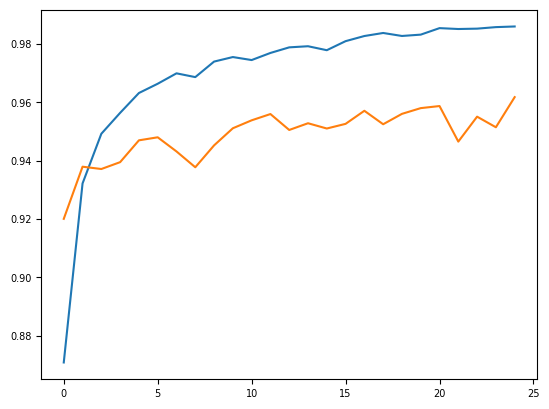

In [ ]:
plt.plot(training_progress_accuracy)
plt.plot(val_progress_accuracy)

## CNN test

I am going to develop two different tests.

### Sample submission test

The first will be seeing the result that my model would give to the Kaggle contest submission file, and we will visually check if we would give the same answer to check how good the response would be.

In [ ]:
testDataset = ImageDataset(df=submission, imgDir='test/', transform=testTransform)
testLoader = DataLoader(dataset=testDataset, batch_size=32, shuffle=False)

In [ ]:
model.eval()

preds=[]
with torch.no_grad():
    for images, _ in testLoader:
        images = images.to(device)

        outputs = model(images)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()

        preds.extend([1 if x >= 0.5 else 0 for x in preds_part])

In [ ]:
preds

[1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,


In [ ]:
submission['has_cactus'] = preds
submission.to_csv('submission.csv', index=False)

First let's see photos that according to our model there are cactus present and then we will see those in which there are no cactus.

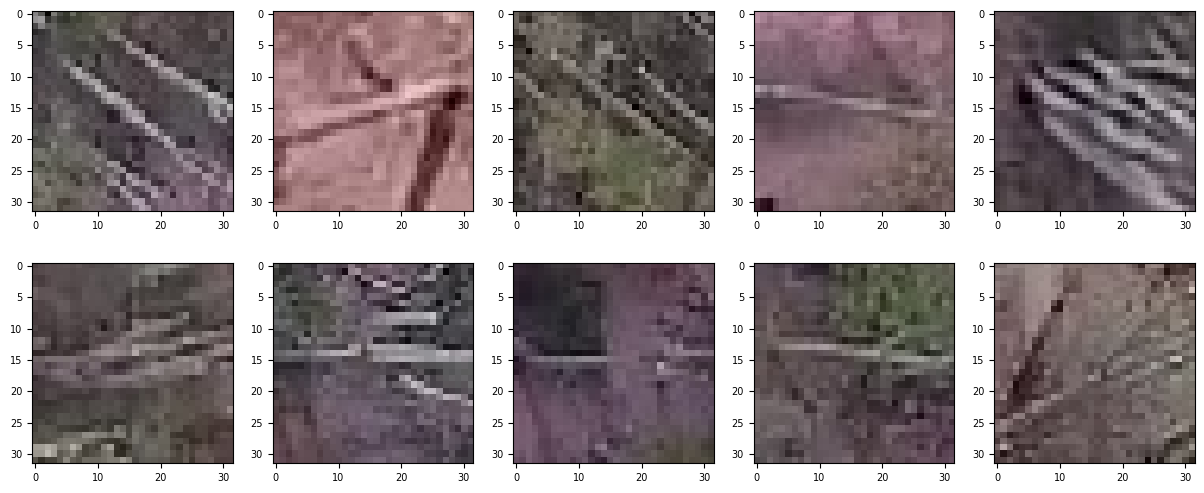

In [ ]:
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 5)

hasCactusImageTest = submission[submission['has_cactus'] == 1]['id'][-10:]

for ind, imgName in enumerate(hasCactusImageTest):
    image = cv2.imread('test/'+imgName)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[ind])
    ax.imshow(image)

It seems that in these 10 photos I would have been correct in saying that there are cactus in all the photos. The only ones we could doubt would be in the second and tenth, since not even we ourselves could be sure if that elongated figure would be a cactus or not.

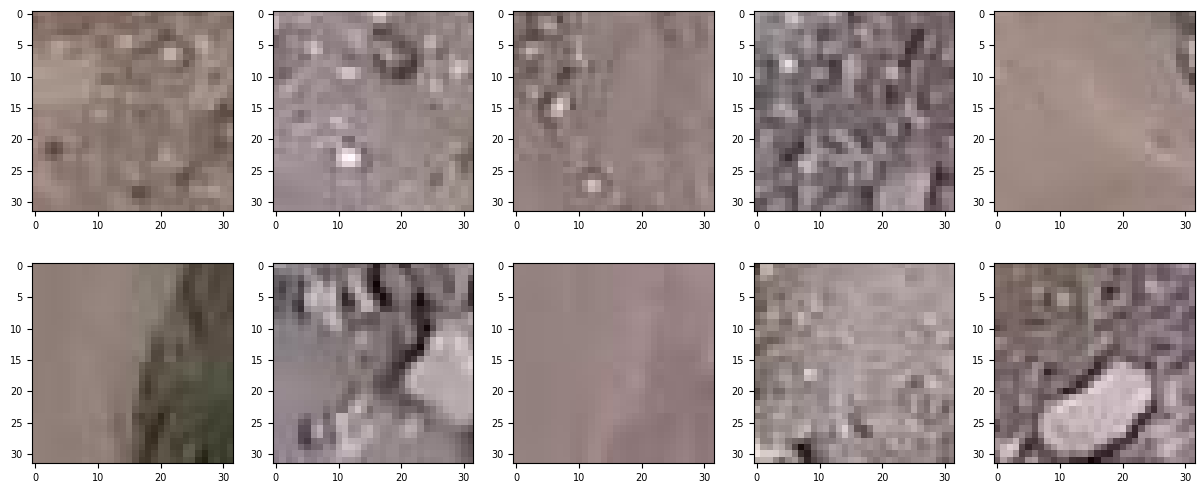

In [ ]:
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(2, 5)

hasntCactusImageTest = submission[submission['has_cactus'] == 0]['id'][-10:]

for ind, imgName in enumerate(hasntCactusImageTest):
    image = cv2.imread('test/'+imgName)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[ind])
    ax.imshow(image)

For me in these 10 photos the model has not been confused at all.

To finish with sample submission test, I am going to show 5 random photos and then I will show what the model said they represent.

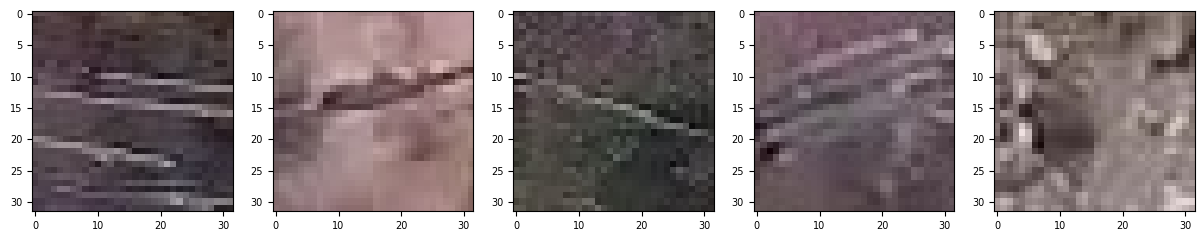

In [ ]:
import random

plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(1, 5)

cactusImageTest = submission['id'].tolist()
randomCactusImageTest=random.sample(cactusImageTest, 5)

for ind, imgName in enumerate(randomCactusImageTest):
    image = cv2.imread('test/'+imgName)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[ind])
    ax.imshow(image)

In [ ]:
for ind, imgName in enumerate(randomCactusImageTest):
  valueHasCactus = submission.loc[submission['id'] == imgName, 'has_cactus'].values[0]
  if (valueHasCactus==1):
    print('For image '+str(ind+1)+' the model says there is a cactus')
  else:
    print('For image '+str(ind+1)+' the model says there is no cactus')

For image 1 the model says there is a cactus
For image 2 the model says there is a cactus
For image 3 the model says there is a cactus
For image 4 the model says there is a cactus
For image 5 the model says there is no cactus


### Cactus photos made by me test

In this test I am going to take photos of different cactus and things that are not cactus such as other plants or terrain. We will convert these photos to 32 x 32 x 3 format and run them through the model to see how useful it would be to determine photos that anyone could take to see if there is a cactus in your surroundings.

In [ ]:
from PIL import Image

for index in range(5):
  image = Image.open('./hasCactus'+str(index)+'.jpeg')
  image_resized = image.resize((32, 32), Image.ANTIALIAS)
  image_resized.save('resizedHasCactus'+str(index)+'.jpg')

for index in range(5):
  image = Image.open('./noHasCactus'+str(index)+'.jpeg')
  image_resized = image.resize((32, 32), Image.ANTIALIAS)
  image_resized.save('resizedNoHasCactus'+str(index)+'.jpg')


<ipython-input-131-6f0cea0cb2eb>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image_resized = image.resize((32, 32), Image.ANTIALIAS)
<ipython-input-131-6f0cea0cb2eb>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image_resized = image.resize((32, 32), Image.ANTIALIAS)


First let's start with images that don't have cactus

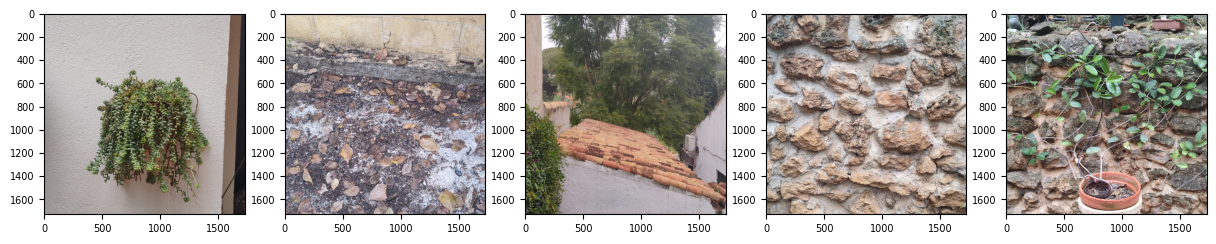

In [ ]:
import matplotlib.image as mpimg

plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(1, 5)

noHasCactusImageReal = ['noHasCactus'+str(index)+'.jpeg' for index in range(5)]

for ind, imgName in enumerate(noHasCactusImageReal):
    image = mpimg.imread(imgName)
    ax = plt.subplot(grid[ind])
    ax.imshow(image)

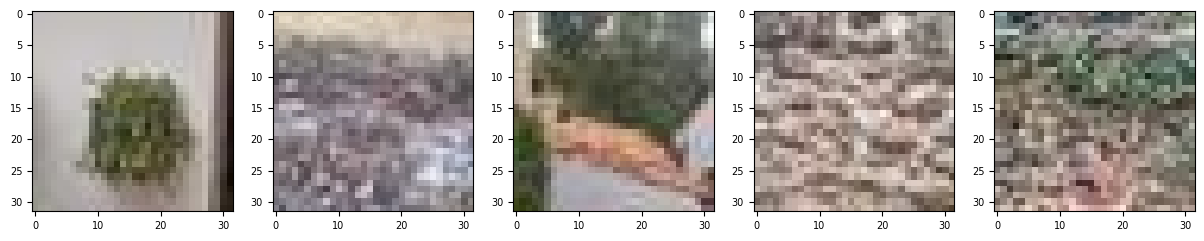

In [ ]:
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(1, 5)

resizedNoHasCactusImageReal = ['resizedNoHasCactus'+str(index)+'.jpg' for index in range(5)]

for ind, imgName in enumerate(resizedNoHasCactusImageReal):
    image = cv2.imread(imgName)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[ind])
    ax.imshow(image)

In [ ]:
model = Model()
model.load_state_dict(torch.load('aerialCactusModel.pth'))
transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(32, padding_mode='symmetric'),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

In [ ]:
index=1
for photo in resizedNoHasCactusImageReal:
  image = Image.open(photo)
  image = transform(image).unsqueeze(0)

  model.eval()

  with torch.no_grad():
    outputs = model(image)

  _, predicted_class = torch.max(outputs, 1)

  if (predicted_class.item()==1):
    print('For image '+str(index)+' the model says there is a cactus')
  else:
    print('For image '+str(index)+' the model says there is no cactus')
  index+=1

For image 1 the model says there is no cactus
For image 2 the model says there is no cactus
For image 3 the model says there is no cactus
For image 4 the model says there is no cactus
For image 5 the model says there is no cactus


The results are as expected, even differentiating cactus from other plants.

Now let's see photos that do have cactus.

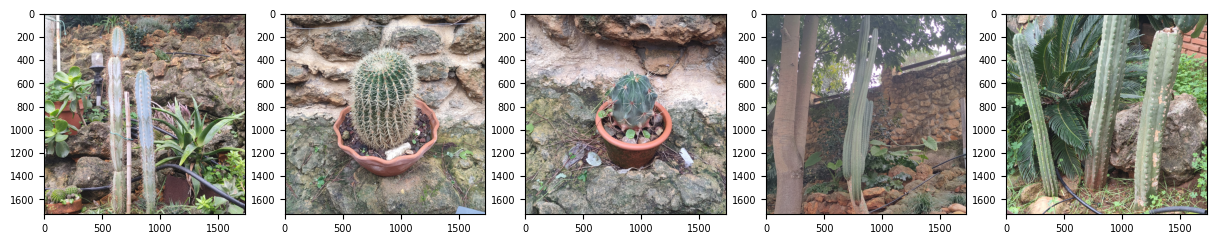

In [ ]:
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(1, 5)

hasCactusImageReal = ['hasCactus'+str(index)+'.jpeg' for index in range(5)]

for ind, imgName in enumerate(hasCactusImageReal):
    image = mpimg.imread(imgName)
    ax = plt.subplot(grid[ind])
    ax.imshow(image)

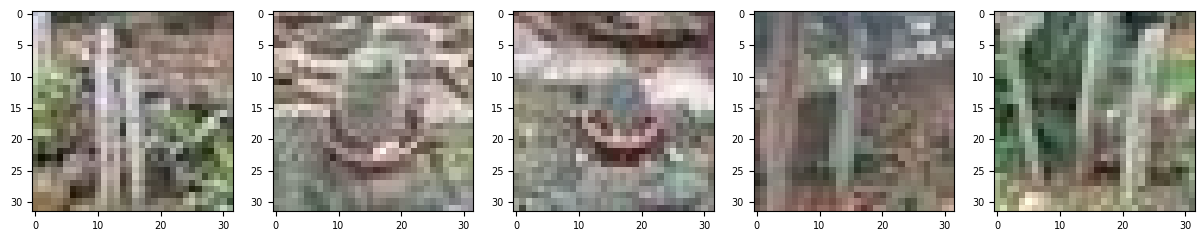

In [ ]:
plt.figure(figsize=(15, 6))
grid = gridspec.GridSpec(1, 5)

resizedHasCactusImageReal = ['resizedHasCactus'+str(index)+'.jpg' for index in range(5)]

for ind, imgName in enumerate(resizedHasCactusImageReal):
    image = cv2.imread(imgName)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[ind])
    ax.imshow(image)

In [ ]:
index=1
for photo in resizedHasCactusImageReal:
  image = Image.open(photo)
  image = transform(image).unsqueeze(0)

  model.eval()

  with torch.no_grad():
    outputs = model(image)

  _, predicted_class = torch.max(outputs, 1)

  if (predicted_class.item()==1):
    print('For image '+str(index)+' the model says there is a cactus')
  else:
    print('For image '+str(index)+' the model says there is no cactus')
  index+=1

For image 1 the model says there is a cactus
For image 2 the model says there is a cactus
For image 3 the model says there is a cactus
For image 4 the model says there is a cactus
For image 5 the model says there is a cactus


As we expected, the result is positive, so it recognizes that there are cactus. Even differentiating more elongated cactus from smaller ones.